# Baby growth plotter
This notebook takes the measurements of a baby's weight, height and head circumference and compares them to average statistics from the World Health Organization.

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime
pd.set_option('display.max_rows', 10)

First, we import the data from the WHO growth table and our measured weights. The datasource is the [WHO](https://www.cdc.gov/growthcharts/who_charts.htm#The%20WHO%20Growth%20Charts)

The table provides the statistical constants we need, but they are only defined on a monthly basis. This isn't sufficient granularity, so we'll need to interpolate the table. I'll make the table daily rather than monthly.

First, however, we will convert the 'Month' column to datetime, starting with the birthdate

In [12]:
# convert to time series with birthdate as start

def construct_baby_growth_table(birthdate,sex='M',characteristic='Weight'):
    if characteristic == 'Weight' and sex =='M':
        file = 'stats/WHO-boys-weight-table.dat'
    elif characteristic == 'Weight' and sex =='F':
        file = 'stats/WHO-girls-weight-table.dat'
    elif characteristic == 'Length' and sex == 'M':
        file = 'stats/WHO-boys-length-table.dat'
    elif characteristic == 'Length' and sex == 'F':
        file = 'stats/WHO-girls-length-table.dat'
    elif characteristic == 'Head' and sex == 'M':
        file = 'stats/WHO-boys-head-table.dat'
    elif characteristic == 'Head' and sex == 'F':
        file = 'stats/WHO-girls-head-table.dat'
    else:
        raise InputError("Please choose 'Weight' or 'Length' for characteristics and 'M' or 'F' for sex")
    data_table = pd.read_csv(file,sep='\t')
    baby_table = pd.DataFrame()

    # Construct a new table starting with the birthdate
    baby_table['Date'] = pd.to_timedelta(data_table['Month'],unit='M') + birthdate
    
    # Copy the stats to the new table
    baby_table[['L','M','S']] = data_table[['L','M','S']]
    
    # Set the date as the index and resample
    baby_table = baby_table.set_index('Date')
    baby_table = baby_table.resample('1D').mean()
    
    # Interpolate the constants
    baby_table = baby_table.interpolate(method='cubic')
    
    return baby_table


Now, we need to interpolate the statistical constants. The default method is linear, but I'm going to use a cubic spline to get nice a nice smooth curve

In [13]:
# the birthdate is Nov-1-2018
birthdate = datetime.datetime(2018,11,1)

elio_weight_table = construct_baby_growth_table(birthdate,sex='M',characteristic='Weight')
elio_length_table = construct_baby_growth_table(birthdate,sex='M',characteristic='Length')
elio_head_table = construct_baby_growth_table(birthdate,sex='M',characteristic='Head')


measurements = pd.read_csv('Elio-measured-weight.tsv',sep='\t')

weights = pd.DataFrame()
weights['Date'] = pd.to_datetime(measurements['Date'],format='%d-%b-%Y')
weights['Weight (kg)'] = measurements['Weight (kg)']
weights = weights[weights['Weight (kg)'].notnull()]

lengths = pd.DataFrame()
lengths['Date'] = pd.to_datetime(measurements['Date'],format='%d-%b-%Y')
lengths['Length (cm)'] = measurements['Length (cm)']
lengths = lengths[lengths['Length (cm)'].notnull()]

head = pd.DataFrame()
head['Date'] = pd.to_datetime(measurements['Date'],format='%d-%b-%Y')
head['Head (cm)'] = measurements['Head (cm)']
head = head[head['Head (cm)'].notnull()]

# Computing Z-scores
To compute the z-score of the weight (X), we need the L, M and S parameters:

$$ Z = \frac{(X/M)^L - 1}{LS}, L \neq 0$$

To compute the weight (X), from a Z-score:

$$X = M(1 + LSZ)^{1/L}, L \neq 0$$

Z-scores can be easily translated into percentiles via the normal distribution

In [14]:
def z_score (date,measurement,table):
    X = measurement
    L, M, S = table.loc[date][['L','M','S']]
    Z = ((X/M)**L - 1)/(L*S)
    return Z
    
def percentile (date,meas,table):
    Z = z_score(date,meas,table)
    return st.norm.cdf(Z)

def weight_from_percentile(date,percentile,table):
    L, M, S = table.loc[date][['L','M','S']]
    Z = st.norm.ppf(percentile)
    X = M*(1 + L*S*Z)**(1/L)
    return X

In [15]:
weight_from_percentile(datetime.datetime(2019,3,31),0.5,elio_weight_table)

7.480375340175485

In [16]:
# Compute the percentile
weights['Percentile'] = weights.apply(lambda row: percentile(row['Date'],row['Weight (kg)'],elio_weight_table), axis=1)
lengths['Percentile'] = lengths.apply(lambda row: percentile(row['Date'],row['Length (cm)'],elio_length_table), axis=1)
head['Percentile'] = head.apply(lambda row: percentile(row['Date'],row['Head (cm)'],elio_head_table), axis=1)

## Projection

I want to take Elio's last few measurements and project up to 20 weeks from the last one. Then we can plot his growth curve against the projection

In [17]:
# Now do the projection 20 weeks from last measurement
projected = pd.DataFrame()
last_meas_date = weights.iloc[-1]['Date']
current_weight_percentile = weights.iloc[-4:]['Percentile'].mean()
current_length_percentile = lengths.iloc[-4:]['Percentile'].mean()
current_head_percentile = head.iloc[-4:]['Percentile'].mean()

# project 20 weeks from last measurement
projected['Date'] = pd.date_range(birthdate,last_meas_date + datetime.timedelta(weeks=20))
projected['Weight (kg)'] = projected.apply(lambda row: weight_from_percentile(row['Date'],current_weight_percentile,elio_weight_table),axis=1)
projected['Weight (kg) (50th)'] = projected.apply(lambda row: weight_from_percentile(row['Date'],.50,elio_weight_table),axis=1)
projected['Length (cm)'] = projected.apply(lambda row: weight_from_percentile(row['Date'],current_length_percentile,elio_length_table),axis=1)
projected['Head (cm)'] = projected.apply(lambda row: weight_from_percentile(row['Date'],current_head_percentile,elio_head_table),axis=1)

## Plotting
Finally, we can do the plot of Elio's weights with the projection based on his current percentile

In [18]:
# Plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import plotly.graph_objs as go
from IPython.display import Image

init_notebook_mode(connected=True)

In [19]:
meas = go.Scatter(x=weights['Date'],
                  y=weights['Weight (kg)'],
                  name='Measured Weights (kg)'
                 )
proj = go.Scatter(x=projected['Date'], 
                  y=projected['Weight (kg)'],
                  name='Projected Weight for {}th Percentile'.format(round(current_weight_percentile*100)),
                  line=dict(dash='dash')
                 )
proj_50 = go.Scatter(x=projected['Date'], 
                  y=projected['Weight (kg) (50th)'],
                  name='Projected Weight for {}th Percentile'.format(round(.50*100)),
                  line=dict(dash='dash')
                 )
layout = go.Layout(title="Elio's Weight measured from birth",
                   yaxis = dict(title='Weight (kg)'),
                   xaxis = dict(title='Date')
                  )
weight_fig = go.Figure(data=[meas,proj,proj_50],layout=layout)

#######################################

meas = go.Scatter(x=lengths['Date'],
                  y=lengths['Length (cm)'],
                  name='Measured Length (cm)'
                 )
proj = go.Scatter(x=projected['Date'], 
                  y=projected['Length (cm)'],
                  name='Projected Length for {}th Percentile'.format(round(current_length_percentile*100)),
                  line=dict(dash='dash')
                 )
layout = go.Layout(title="Elio's length measured from birth",
                   yaxis = dict(title='Length (cm)'),
                   xaxis = dict(title='Date')
                  )
length_fig = go.Figure(data=[meas,proj],layout=layout)

#######################################

meas = go.Scatter(x=head['Date'],
                  y=head['Head (cm)'],
                  name='Measured Head Circumference (cm)'
                 )
proj = go.Scatter(x=projected['Date'], 
                  y=projected['Head (cm)'],
                  name='Projected head circumference for {}th Percentile'.format(round(current_head_percentile*100)),
                  line=dict(dash='dash')
                 )
layout = go.Layout(title="Elio's head circumference measured from birth",
                   yaxis = dict(title='Head Circumference (cm)'),
                   xaxis = dict(title='Date')
                  )
head_fig = go.Figure(data=[meas,proj],layout=layout)


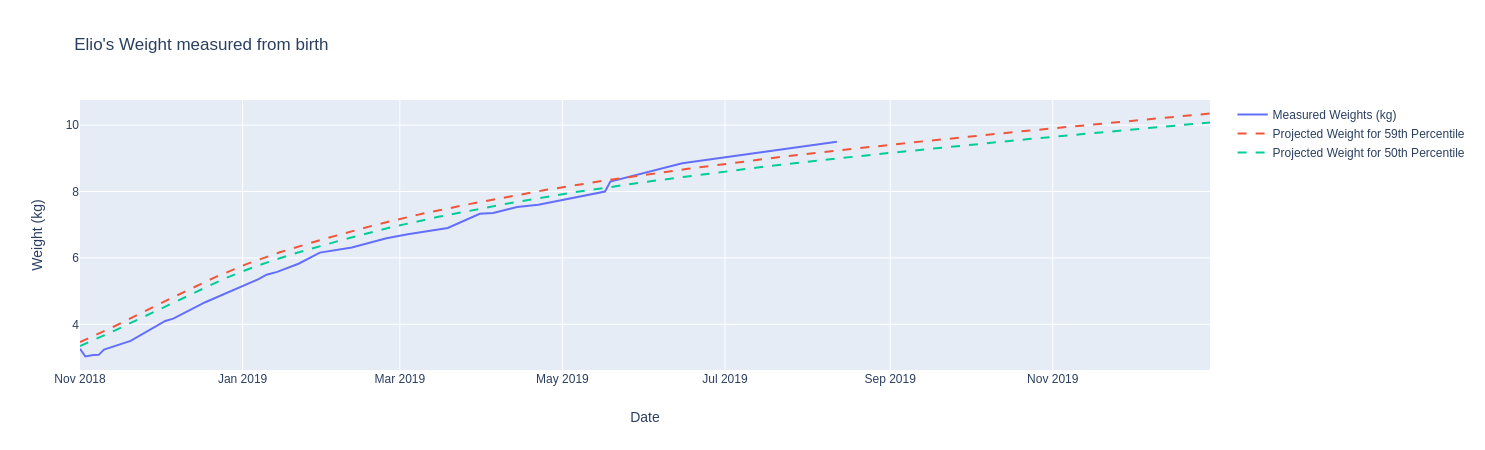

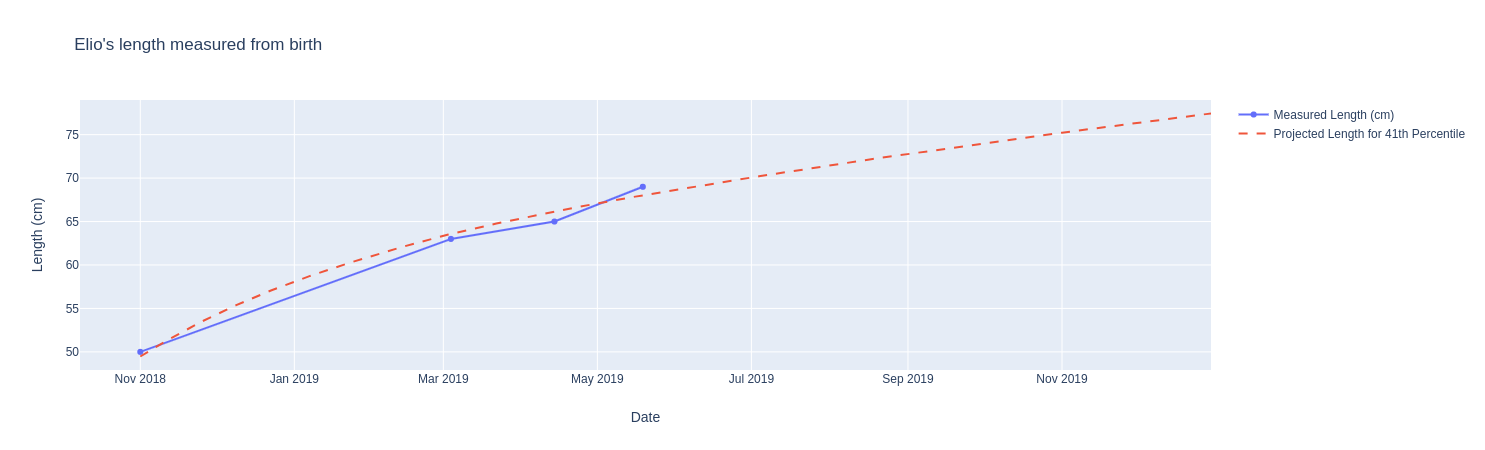

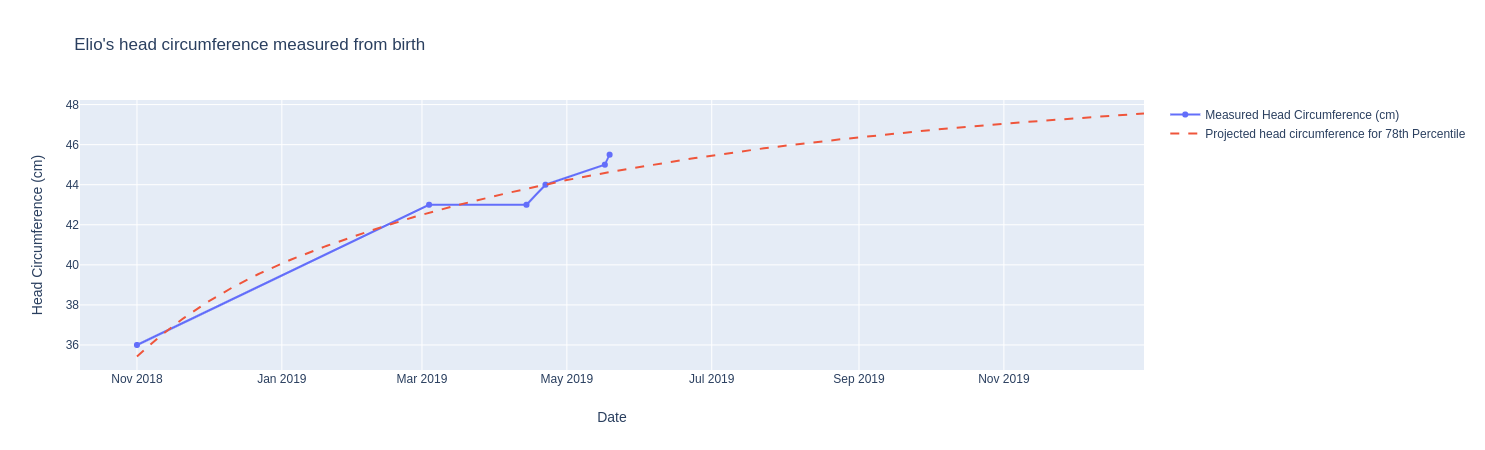

In [20]:
#Image(pio.to_image(w_fig,width=1200,height=600))

iplot(weight_fig) # interative
iplot(length_fig)
iplot(head_fig)